In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

%matplotlib inline

In [11]:
def show_image(filename):
    rgb = Image.open('../data/Train/CameraRGB/'+filename)
    plt.imshow(np.asarray(rgb))
    plt.show()
    seg = Image.open('../data/Train/CameraSeg/'+filename)
    plt.imshow(np.asarray(seg)[:,:,0])
    plt.show()

def filter_seg(filename):
    img = Image.open('../data/Train/CameraSeg/'+filename)
    label = np.array(img, dtype=np.uint8)
    label[label == 6] = 7
    label[np.isin(label, [7,10], invert=True)] = 0
    label[490:,:,:][label[490:,:,:] != 7] = 0
    return label

In [17]:
label_image[500,0,2]

0

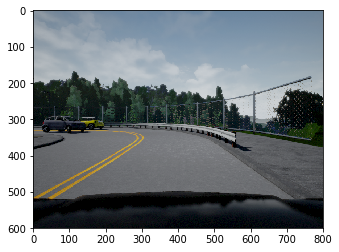

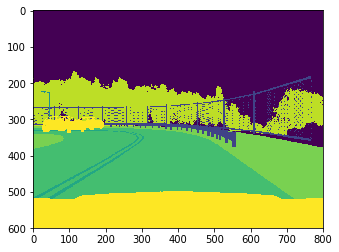

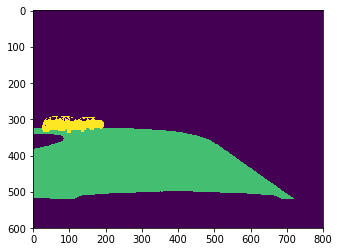

In [12]:
filename = '88.png'
show_image(filename)
label_image = filter_seg(filename)
plt.imshow(label_image[:,:,0])
plt.show()

In [19]:
if not os.path.exists('../data/Test'):
    os.makedirs('../data/Test/CameraRGB')
    os.makedirs('../data/Test/CameraSeg')
    
img_files = [str(filename) + '.png' for filename in range(950,1000)]
for filename in img_files:
    rgb = '../data/Train/CameraRGB/' + filename
    seg = '../data/Train/CameraSeg/' + filename
    if os.path.isfile(rgb):
        shutil.move(rgb, '../data/Test/CameraRGB/')
    if os.path.isfile(seg):
        shutil.move(seg, '../data/Test/CameraSeg/')

In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import helper
import project_tests as tests

In [2]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Devices: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Devices: /device:GPU:0


In [3]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    image_input = sess.graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = sess.graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out = sess.graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out = sess.graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out = sess.graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return image_input, keep_prob, layer3_out, layer4_out, layer7_out

tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [4]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """ 
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    layer7 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    layer4 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    layer3 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))

    output = tf.layers.conv2d_transpose(layer7, num_classes, 4, 2, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    output = tf.add(output, layer4)

    output = tf.layers.conv2d_transpose(output, num_classes, 4, 2, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    output = tf.add(output, layer3)

    output = tf.layers.conv2d_transpose(output, num_classes, 16, 8, padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))

    return output

tests.test_layers(layers)

Tests Passed


In [5]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))
    cross_entropy_loss += sum(reg_losses)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
    
    return logits, train_op, cross_entropy_loss

tests.test_optimize(optimize)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Tests Passed


In [6]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    sess.run(tf.global_variables_initializer())
    i = 0
    for epoch in range(epochs):
        for batch_xs, batch_ys in get_batches_fn(batch_size):
            feed_dict = {
                input_image: batch_xs,
                correct_label: batch_ys,
                keep_prob: 0.85,
                learning_rate: 0.001
            }
            sess.run(train_op, feed_dict=feed_dict)
            
            if i % 10 == 0:
                loss = sess.run(cross_entropy_loss, feed_dict=feed_dict)
                print("Epoch:{} Iteration:{} Loss:{}".format(epoch, i, loss))
            i += 1
            
tests.test_train_nn(train_nn)

INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from b'../data/vgg/variables/variables'


In [9]:
def run():
    num_classes = 3
    image_shape = (600, 800)
    data_dir = '../data'
    runs_dir = './runs'
    tests.test_for_lyft_dataset(data_dir)
    
    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)
    
    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'Train'), image_shape)
        
        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
        layers_output = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        correct_label = tf.placeholder(tf.float32, [None, None, None, num_classes])
        learning_rate = tf.placeholder(tf.float32)
        logits, train_op, cross_entropy_loss = optimize(layers_output, correct_label, learning_rate, num_classes)
        
        epochs = 50
        batch_size = 10
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image, correct_label, keep_prob, learning_rate)
        
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)   

In [10]:
run()

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: save/Assign_27 = Assign[T=DT_FLOAT, _class=["loc:@fc6/weights"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc6/weights, save/RestoreV2_27/_7)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'save/Assign_27', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-ec9775ede022>", line 1, in <module>
    run()
  File "<ipython-input-7-4c9cb4fdd672>", line 24, in run
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
  File "<ipython-input-3-00b61416e9f4>", line 15, in load_vgg
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/saved_model/loader_impl.py", line 216, in load
    saver = tf_saver.import_meta_graph(meta_graph_def_to_load, **saver_kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1838, in import_meta_graph
    **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/meta_graph.py", line 660, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 316, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/importer.py", line 554, in import_graph_def
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: save/Assign_27 = Assign[T=DT_FLOAT, _class=["loc:@fc6/weights"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fc6/weights, save/RestoreV2_27/_7)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

